# Data from Frankefunction

In [1]:
import sys
sys.path.insert(1, '../')

In [2]:
from functions import *
#from main import * 

In [3]:
x,y,z = generate_data()

Defining variables next: 

In [4]:
degrees = np.linspace(1,11,11)

bias = np.zeros(len(degrees))
variance = np.zeros(len(degrees))

test_MSE_OLS = np.zeros(len(degrees))
test_R2 = np.zeros(len(degrees))

train_MSE = np.zeros(len(degrees))
train_R2 = np.zeros(len(degrees))


# Ordinary Least Square

Performing 5 fold cross-validation with our 'OLS'.

In [5]:
k = 5 #cross fold
for polygrad in degrees:

    j = int(polygrad) - 1
    scores, betas_OLS = bias_variance(x,y,z,polygrad,k, regressiontype='OLS')

    train_MSE[j] = scores[0]
    train_R2[j] = scores[1]

    test_MSE_OLS[j] = scores[2]
    bias[j] = scores[3]
    variance[j] = scores[4]
    if (test_MSE_OLS[j]>= (bias[j]+variance[j])):
        print ("Correct: ")
    else :
        print ("MSE is not equal to variance + bias^2 by : {}".format(test_MSE_OLS[j]-(bias[j]+variance[j])))
    print('{} >= {} + {} = {}'.format(test_MSE_OLS[j],bias[j], variance[j], bias[j]+variance[j]))
    print (" ")

Correct: 
0.0280345244496956 >= 0.02802040512283856 + 1.4119326857032015e-05 = 0.02803452444969559
 
Correct: 
0.018787448611445386 >= 0.01873536628359517 + 5.2082327850215374e-05 = 0.018787448611445386
 
MSE is not equal to variance + bias^2 by : -1.734723475976807e-18
0.00844797342915526 >= 0.008391706744422831 + 5.62666847324303e-05 = 0.008447973429155261
 
Correct: 
0.003909361008675411 >= 0.003844665778271865 + 6.46952304035451e-05 = 0.00390936100867541
 
MSE is not equal to variance + bias^2 by : -8.673617379884035e-19
0.003812155120745757 >= 0.003744736155359589 + 6.741896538616883e-05 = 0.003812155120745758
 
Correct: 
0.0032509819676118435 >= 0.003077365700558312 + 0.00017361626705353106 = 0.003250981967611843
 
Correct: 
0.0007372565848313514 >= 0.0006708616028787404 + 6.639498195261089e-05 = 0.0007372565848313514
 
Correct: 
0.0005663690139480076 >= 0.0004969341540134731 + 6.943485993453447e-05 = 0.0005663690139480075
 
MSE is not equal to variance + bias^2 by : -2.168404344

Here we would like to compare our test and train MSE, and also look at our variance and bias trade-off as a function. 

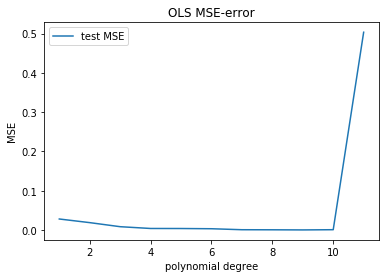

In [6]:
plt.plot(degrees,test_MSE_OLS)
#plt.plot(degrees,train_MSE)
plt.xlabel("polynomial degree")
plt.ylabel("MSE")
plt.title("OLS MSE-error")
plt.legend(["test MSE","train MSE"])

Here we can see that to avoid overfitting we should choose a polynomial degree of 8.

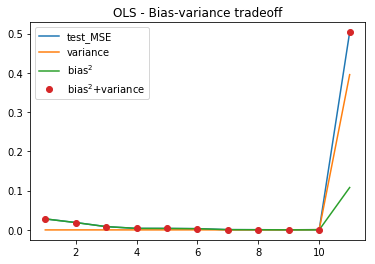

In [7]:
plt.plot(degrees,test_MSE_OLS)
plt.plot(degrees,variance)
plt.plot(degrees,bias)
plt.title("OLS - Bias-variance tradeoff")
plt.plot(degrees,variance+bias,'o')
plt.legend(["test_MSE","variance", "bias$^2$","bias$^2$+variance"])    
plt.show()

100%|██████████| 11/11 [00:01<00:00,  7.27it/s]


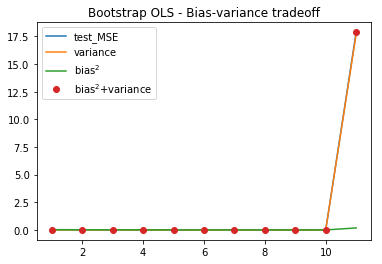

In [8]:
x_train, x_test, y_train, y_test, z_train, z_test = train_test_split(x,y,z,test_size=0.2)
import tqdm
#make a design matrix for the test data
mse = np.zeros(len(degrees))
r2 = np.zeros(len(degrees))
bias = np.zeros(len(degrees))
variance = np.zeros(len(degrees))

n_bootstraps = 100
from sklearn.utils import resample
#initialize matrix for storing the predictions
z_pred = np.empty((z_test.shape[0], n_bootstraps))
for degree in tqdm.tqdm(degrees):
    X_test = find_designmatrix(x_test, y_test, polygrad=degree)
    #preforming n_bootstraps sycles
    for i in range(n_bootstraps):
        
        x_, y_, z_ = resample(x_train, y_train, z_train)
        X = find_designmatrix(x_, y_, polygrad=degree)
        beta = OLS(X, z_)
        z_pred_temp = X_test @ beta
        #storing the prediction for evaluation
        z_pred[:, i] = z_pred_temp.ravel()

    z_test = np.reshape(z_test,(len(z_test),1))

    #evaluate predictions
    mse[int(degree)-1] = np.mean( np.mean((z_test - z_pred)**2, axis=1, keepdims=True) )
    r2[int(degree)-1] = np.mean(1 - np.sum((z_test - z_pred)**2, axis=1, keepdims=True)\
                 /np.sum((z_test - np.mean(z_test))**2, axis=1, keepdims=True) )
    bias[int(degree)-1] = np.mean( (z_test - np.mean(z_pred, axis=1, keepdims=True))**2 )
    variance[int(degree)-1] = np.mean( np.var(z_pred, axis=1, keepdims=True) )
    
plt.plot(degrees,mse)
plt.plot(degrees,variance)
plt.plot(degrees,bias)
plt.title("Bootstrap OLS - Bias-variance tradeoff")
plt.plot(degrees,variance+bias,'o')
plt.legend(["test_MSE","variance", "bias$^2$","bias$^2$+variance"])    
plt.show()

11


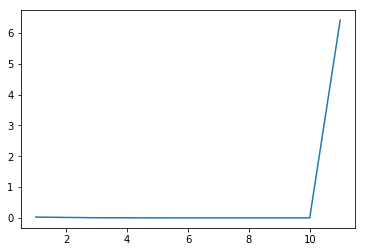

In [9]:
test_bootstrap_error = bootstrap(x,y,z,degrees,'OLS')
plt.plot(degrees,test_bootstrap_error)
plt.show()

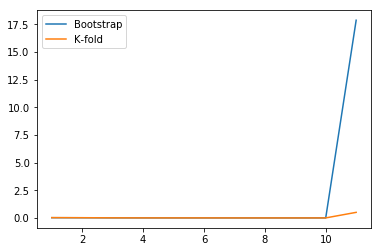

In [10]:
plt.plot(degrees,mse)
plt.plot(degrees,test_MSE_OLS)
plt.legend(["Bootstrap","K-fold"])
plt.show()

# Ridge regression

We will do much of the same analysis as we did above, but first we need to check which hyperparameter lambda is best. 

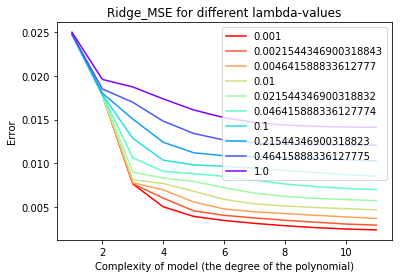

In [11]:
    
nlambdas = 10
lambdas = np.logspace(-3,0,nlambdas)
    
color=iter(cm.rainbow(np.linspace(1,0,nlambdas)))
    
for lamb in lambdas:  
        test2_MSE = Different_Lambdas(x, y, z, degrees, k, lamb, regressiontype='Ridge')       
    
        c = next(color)
        plt.plot(degrees,test2_MSE, c=c)
        plt.legend(lambdas)
        plt.xlabel("Complexity of model (the degree of the polynomial)")
        plt.ylabel("Error")
        plt.title("Ridge_MSE for different lambda-values")
plt.show()

As we can see, the lower the $\lambda$, the better. Thus, we will use $10^{-4}$ as our $\lambda$.

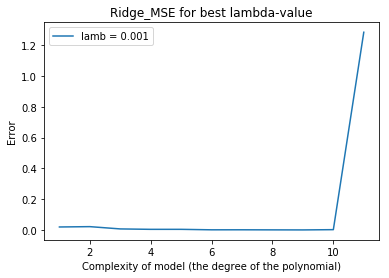

In [12]:
lamb = 1e-5

test_MSE_Ridge, Bias, Variance, beta_Ridge = Best_Lambda(x, y, z, degrees, k, lamb, regressiontype='Ridge')

plt.plot(degrees,test_MSE_Ridge)
plt.legend(["lamb = 0.001"])
plt.xlabel("Complexity of model (the degree of the polynomial)")
plt.ylabel("Error")
plt.title("Ridge_MSE for best lambda-value")
plt.show()

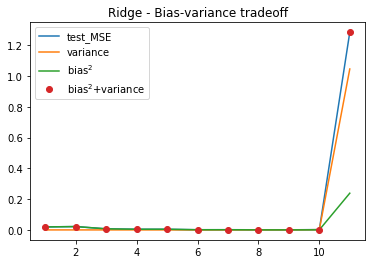

In [13]:
plt.plot(degrees,test_MSE_Ridge)
plt.plot(degrees,Variance)
plt.plot(degrees,Bias)
plt.title("Ridge - Bias-variance tradeoff")
plt.plot(degrees,Variance+Bias,'o')
plt.legend(["test_MSE","variance", "bias$^2$","bias$^2$+variance"])    
plt.show()

# LASSO regression

100%|██████████| 10/10 [00:02<00:00,  4.65it/s]


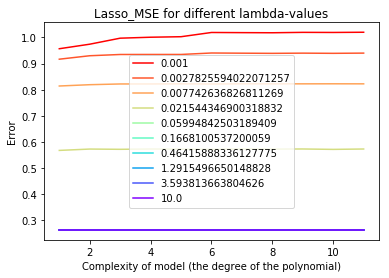

In [14]:
color=iter(cm.rainbow(np.linspace(1,0,nlambdas)))
from tqdm import tqdm
lambdas = np.logspace(-3,1,nlambdas)

for lamb in tqdm(lambdas):

        test_MSE_LASSO = Different_Lambdas(x, y, z, degrees, k, lamb, regressiontype='Lasso')
        
        c = next(color)
        plt.plot(degrees,test_MSE_LASSO, c=c)
        plt.legend(lambdas)
        plt.xlabel("Complexity of model (the degree of the polynomial)")
        plt.ylabel("Error")
        plt.title("Lasso_MSE for different lambda-values")
plt.show()

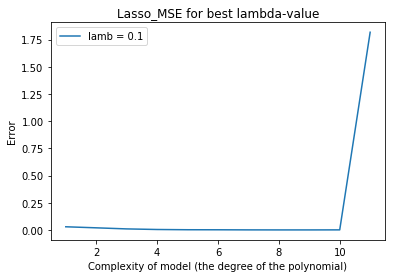

In [15]:
    lamb = 0.1

    test_MSE_LASSO, Bias, Variance, betas_LASSO = Best_Lambda(x, y, z, degrees, k, lamb, regressiontype='Lasso')

    plt.plot(degrees,test_MSE_LASSO)
    plt.legend(["lamb = 0.1"])
    plt.title("Lasso_MSE for best lambda-value")
    plt.xlabel("Complexity of model (the degree of the polynomial)")
    plt.ylabel("Error")
    plt.show()


# What is the best model?

Now we can try to find out which model is the best. A simple plot of the different regression models with the best $\lambda$ functions will do. 

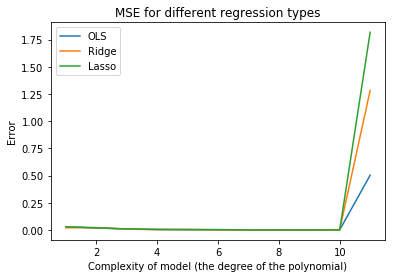

In [16]:
plt.plot(degrees,test_MSE_OLS)
plt.plot(degrees,test_MSE_Ridge)
plt.plot(degrees,test_MSE_LASSO)
plt.xlabel("Complexity of model (the degree of the polynomial)")
plt.ylabel("Error")
plt.title("MSE for different regression types")
plt.legend(["OLS","Ridge","Lasso"])
plt.show()

Here we can see that OLS at polynomial degree 9 has the closest MSE to zero. And we can also find the confidence intervals. 

In [17]:
def confidence_interval1(beta, MSE):
    sigma = np.sqrt(MSE)
    mean_beta = 0
    for i in beta:
        mean_beta += (i)
    print (beta)
    print ("confidence interval is from %2.4f to %2.4f." %
            (mean_beta/i-sigma*1.96, mean_beta/i+sigma*1.96))
    print ("MSE is", (MSE))
    return (mean_beta+sigma*1.96)

scores, betas_OLS = bias_variance(x,y,z,8,k, regressiontype='OLS')
#scores, betas_Ridge = bias_variance(x,y,z,8,k,regressiontype='Ridge')
#scores, betas_Lasso = bias_variance(x,y,z,8,k,regressiontype='LASSO')
print (betas_OLS[0])
CI_OLS = np.zeros(len(test_MSE_OLS))
#CI_Ridge = np.zeros(len(test_MSE_OLS))
#CI_LASSO = np.zeros(len(test_MSE_OLS))

#for i in range(len(test_MSE_OLS)):
#    CI_OLS[i] = confidence_interval1(betas_OLS[i,:],test_MSE_OLS[i])
    #CI_Ridge[i] = confidence_interval1(betas_Ridge[i,:],test_MSE_Ridge[i]) 
    #CI_LASSO[i] = confidence_interval1(betas_LASSO[i,:],test_MSE_LASSO[i])
    
#confidence_interval(betas_Ridge[:,-1],test_MSE_Ridge)
#confidence_interval(betas_[:,-1],test_MSE_LASSO)


"""
fig = plt.figure()
x = np.arange(10)
print (len(degrees), len(test_MSE_OLS),len(CI_OLS))
plt.errorbar(degrees, test_MSE_OLS , yerr=CI_OLS, uplims=True, lolims=True,
             label='uplims=True, lolims=True')


plt.legend(loc='lower right')
"""

[0.81106052 0.79727907 1.12861983 0.81154468 0.81298834]


"\nfig = plt.figure()\nx = np.arange(10)\nprint (len(degrees), len(test_MSE_OLS),len(CI_OLS))\nplt.errorbar(degrees, test_MSE_OLS , yerr=CI_OLS, uplims=True, lolims=True,\n             label='uplims=True, lolims=True')\n\n\nplt.legend(loc='lower right')\n"

In [18]:
"""
fig = plt.figure()
x = np.arange(10)
y = 2.5 * np.sin(x / 20 * np.pi)
yerr = np.linspace(0.05, 0.2, 10)


plt.errorbar(x, y + 1, yerr=yerr, uplims=True, lolims=True,
             label='uplims=True, lolims=True')

#upperlimits = [True, False] * 5
#lowerlimits = [False, True] * 5

plt.legend(loc='lower right')
"""

"\nfig = plt.figure()\nx = np.arange(10)\ny = 2.5 * np.sin(x / 20 * np.pi)\nyerr = np.linspace(0.05, 0.2, 10)\n\n\nplt.errorbar(x, y + 1, yerr=yerr, uplims=True, lolims=True,\n             label='uplims=True, lolims=True')\n\n#upperlimits = [True, False] * 5\n#lowerlimits = [False, True] * 5\n\nplt.legend(loc='lower right')\n"